## GEN DATASET

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

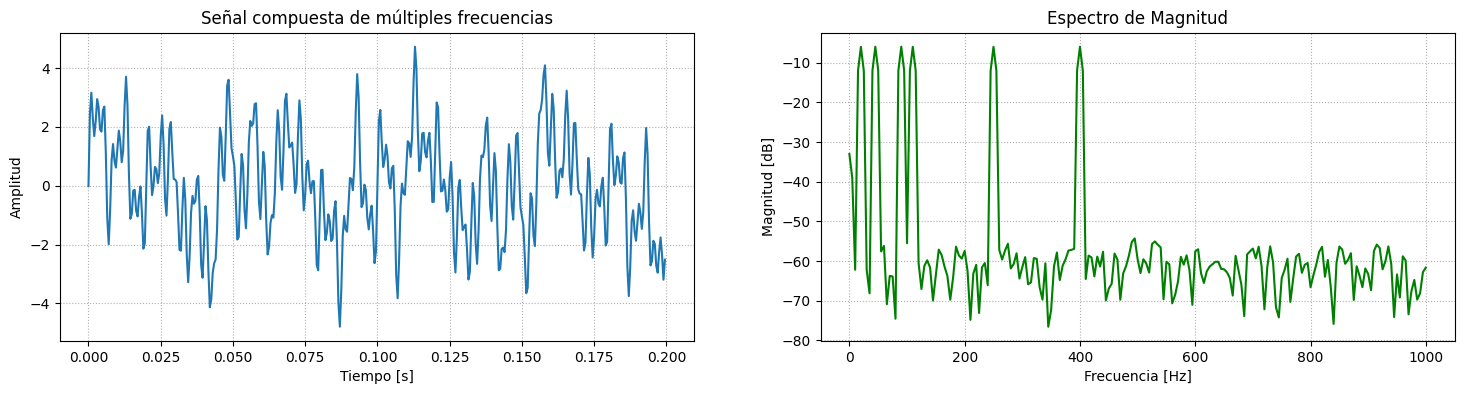

In [2]:
f1 = 20
f2 = 45
f3 = 90
f4 = 110
f5 = 250
f6 = 400

fs = 2000
ts = 1/fs
time = 0.2

N = time/ts
n = np.arange(0, int(N))
t = n*ts

noise = 0.5*np.random.uniform(-0.1, 0.01, len(t))

x = (np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + np.sin(2*np.pi*f3*t) +
     np.sin(2*np.pi*f4*t) + np.sin(2*np.pi*f5*t) + np.sin(2*np.pi*f6*t)) + noise

plt.figure(figsize=(18, 4))
plt.subplot(1,2,1)
plt.plot(t, x)
plt.title('Señal compuesta de múltiples frecuencias')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(ls=":")
#plt.xlim(0, 0.1)

plt.subplot(1,2,2)
plt.magnitude_spectrum(x, Fs=fs, scale='dB', color='green')
plt.title('Espectro de Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(ls=":")
plt.show()

In [3]:
class Gen_DB_sin():
    def __init__(self, f, fs=1e3, duration=1.0, noise_std=0.02, phi=0):
        self.f = f
        self.fs = fs
        self.duration = duration
        self.noise_std = noise_std
        self.ts = 1/fs
        self.phi = phi
        self.n_samples = int(fs * duration)
        self.t = np.arange(self.n_samples) * self.ts

    def generate_single_sample(self):
        phi = np.random.randint(0, self.phi)
        sin_aux = 0
        for i in self.f:
            sin_aux += np.sin(2*np.pi*i*self.t + phi)
        noise = np.random.normal(0, self.noise_std, self.n_samples)
        x_noised = sin_aux + noise
        return x_noised
    
    def generate_dataset(self, n_samples):
        X = []
        for _ in range(n_samples):
            x = self.generate_single_sample()
            X.append(x)
        return np.array(X)

In [8]:
"""f1 = 20
f2 = 45
f3 = 90
f4 = 110
f5 = 250
f6 = 400"""

fs = 2e3
duration = 0.2
noise_std=0.1
phi = 3*np.pi/4
freqs = [20,45,90,110,250,400]

Gen_DB_sin_instance = Gen_DB_sin(f=freqs, fs=fs, duration=duration, noise_std=noise_std, phi=phi)
X_dataset = Gen_DB_sin_instance.generate_dataset(n_samples=500)

X_dataset

array([[ 5.25359431e+00,  5.56313474e+00,  4.11959469e+00, ...,
        -6.72429426e-04,  5.23394888e-01,  2.80986361e+00],
       [ 4.91312945e+00,  5.42531446e+00,  4.22460640e+00, ...,
        -2.59078274e-02,  5.76542735e-01,  2.69226120e+00],
       [ 4.98392390e+00,  5.55530797e+00,  3.92980123e+00, ...,
         2.14447602e-01,  6.42602375e-01,  2.61079522e+00],
       ...,
       [ 5.13231182e+00,  5.53959968e+00,  4.12406571e+00, ...,
        -1.05474224e-02,  4.67075230e-01,  2.76458897e+00],
       [-2.65881204e-02,  2.47181219e+00,  3.21684922e+00, ...,
        -2.43195510e+00, -3.09584798e+00, -2.67445121e+00],
       [ 4.85860219e+00,  5.27388363e+00,  3.96572279e+00, ...,
        -1.28418361e-01,  7.49272041e-01,  2.75950112e+00]],
      shape=(500, 400))

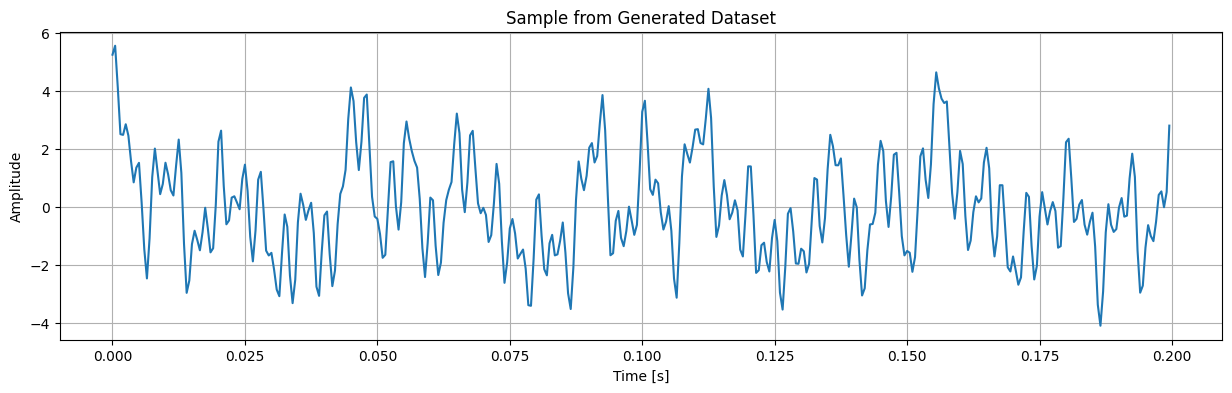

In [9]:
plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()

## DataLoader 

In [12]:
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)

class SineWaveDataset:
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]
    

def get_dataloader(data, batch_size=32, shuffle=True):
    dataset = SineWaveDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


#batch_size = 64
#dataloader = get_dataloader(X_dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Normalizar al rango [-1, 1] para coincidir con Tanh
X_min = X_dataset.min()
X_max = X_dataset.max()
X_dataset_normalized = 2 * (X_dataset - X_min) / (X_max - X_min) - 1

print(f"Original range: [{X_min:.3f}, {X_max:.3f}]")
print(f"Normalized range: [{X_dataset_normalized.min():.3f}, {X_dataset_normalized.max():.3f}]")

Original range: [-5.057, 5.707]
Normalized range: [-1.000, 1.000]


In [14]:
# Mejorado: Inicialización de pesos + Arquitectura más profunda
def weights_init(m):
    """Inicialización de pesos según DCGAN"""
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator mejorado (más capas, mejor regularización)
class Generator(nn.Module):
    def __init__(self, noise_dim=128, output_dim=200):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256), 
            nn.BatchNorm1d(256), 
            nn.LeakyReLU(0.2, True),
            
            nn.Linear(256, 512), 
            nn.BatchNorm1d(512), 
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 1024), 
            nn.BatchNorm1d(1024), 
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 1024), 
            nn.BatchNorm1d(1024), 
            nn.LeakyReLU(0.2, True),
            
            nn.Linear(1024, output_dim),
            nn.Tanh()  # Salida en [-1, 1]
        )
        
    def forward(self, z): 
        return self.model(z)

# Discriminator mejorado (más capaz, sin BatchNorm)
class Discriminator(nn.Module):
    def __init__(self, input_dim=200):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024), 
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512), 
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256), 
            nn.LeakyReLU(0.2, True),
            
            nn.Linear(256, 1)  # logits para BCEWithLogitsLoss
        )
        
    def forward(self, x): 
        return self.model(x.view(x.size(0), -1))

Epoch [50/1000], D Loss: 0.3302, G Loss: 0.0000
Epoch [100/1000], D Loss: 0.4524, G Loss: 0.0000


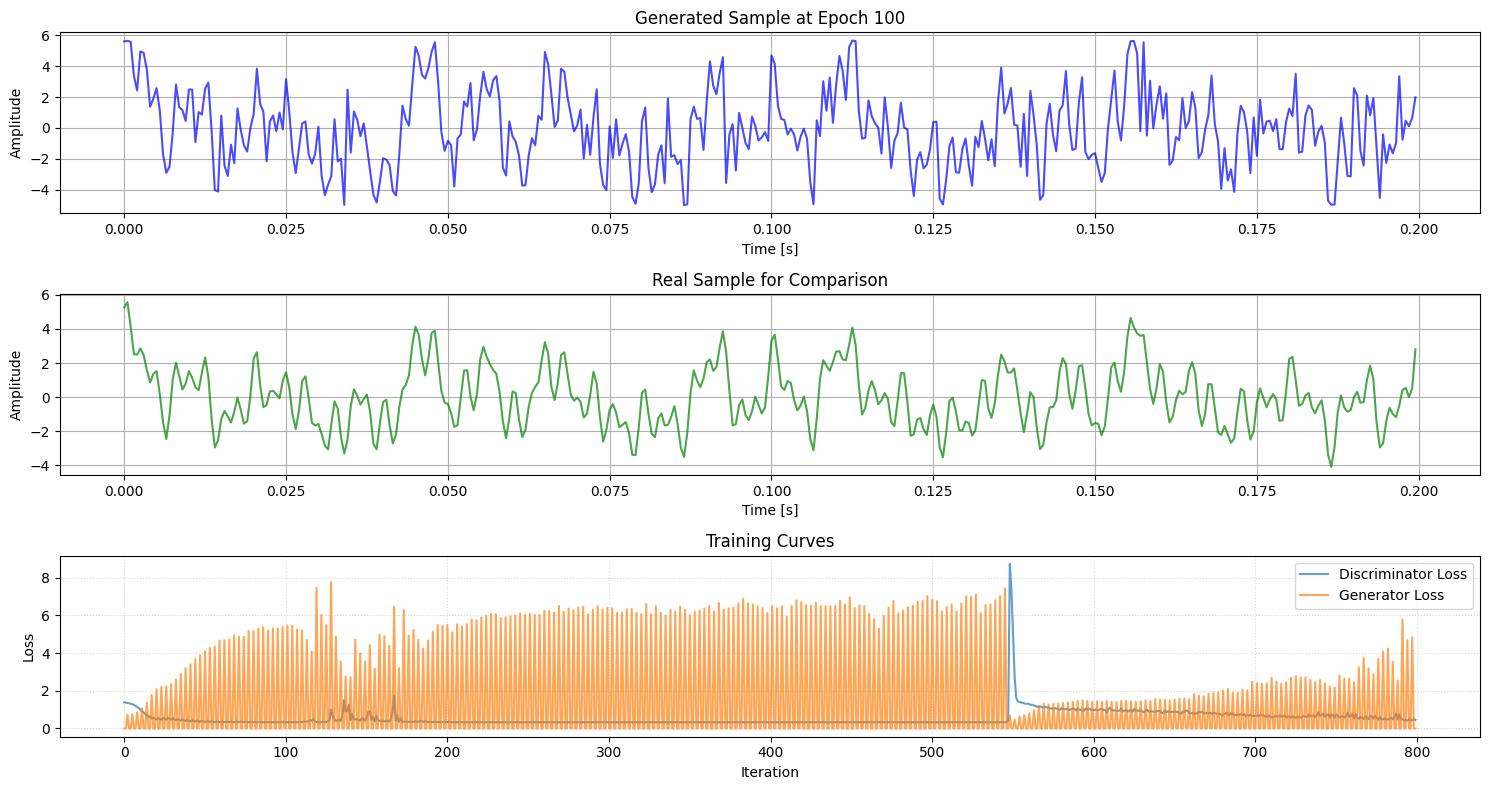

Epoch [150/1000], D Loss: 0.5216, G Loss: 3.5648
Epoch [200/1000], D Loss: 0.6912, G Loss: 0.0000


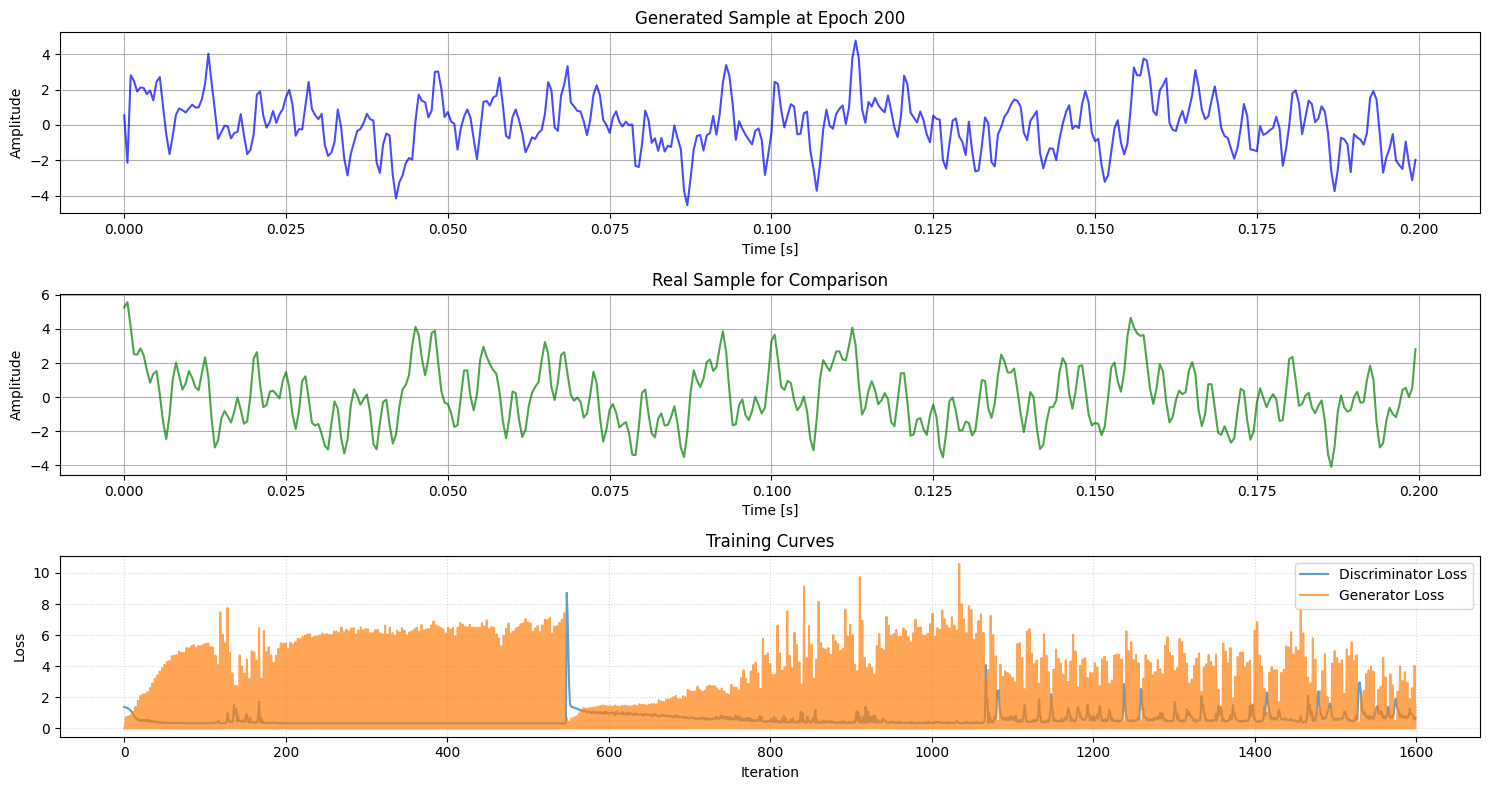

Epoch [250/1000], D Loss: 1.3306, G Loss: 0.0000
Epoch [300/1000], D Loss: 1.0072, G Loss: 2.1351


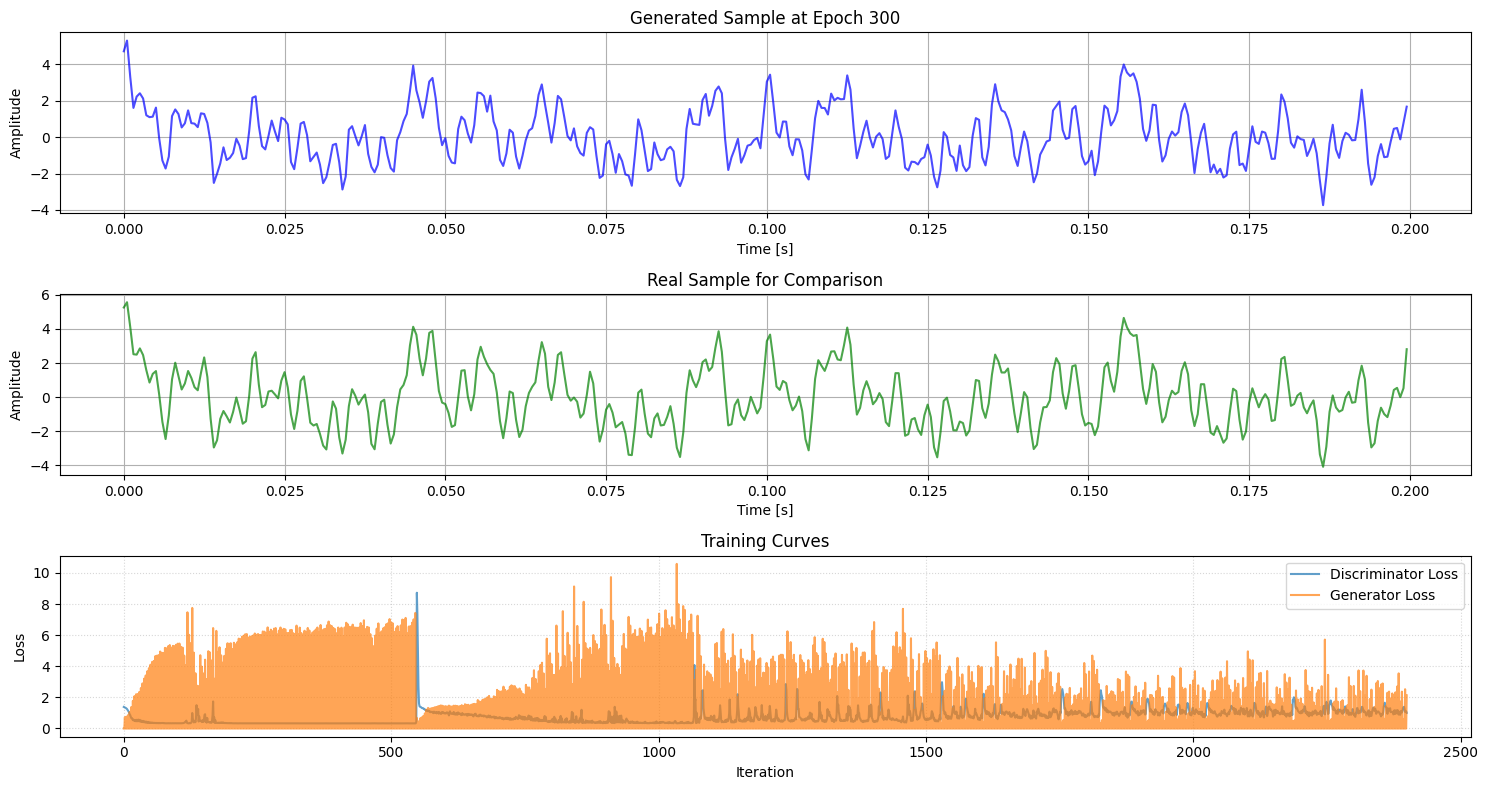

Epoch [350/1000], D Loss: 1.2941, G Loss: 0.0000
Epoch [400/1000], D Loss: 1.1850, G Loss: 0.0000


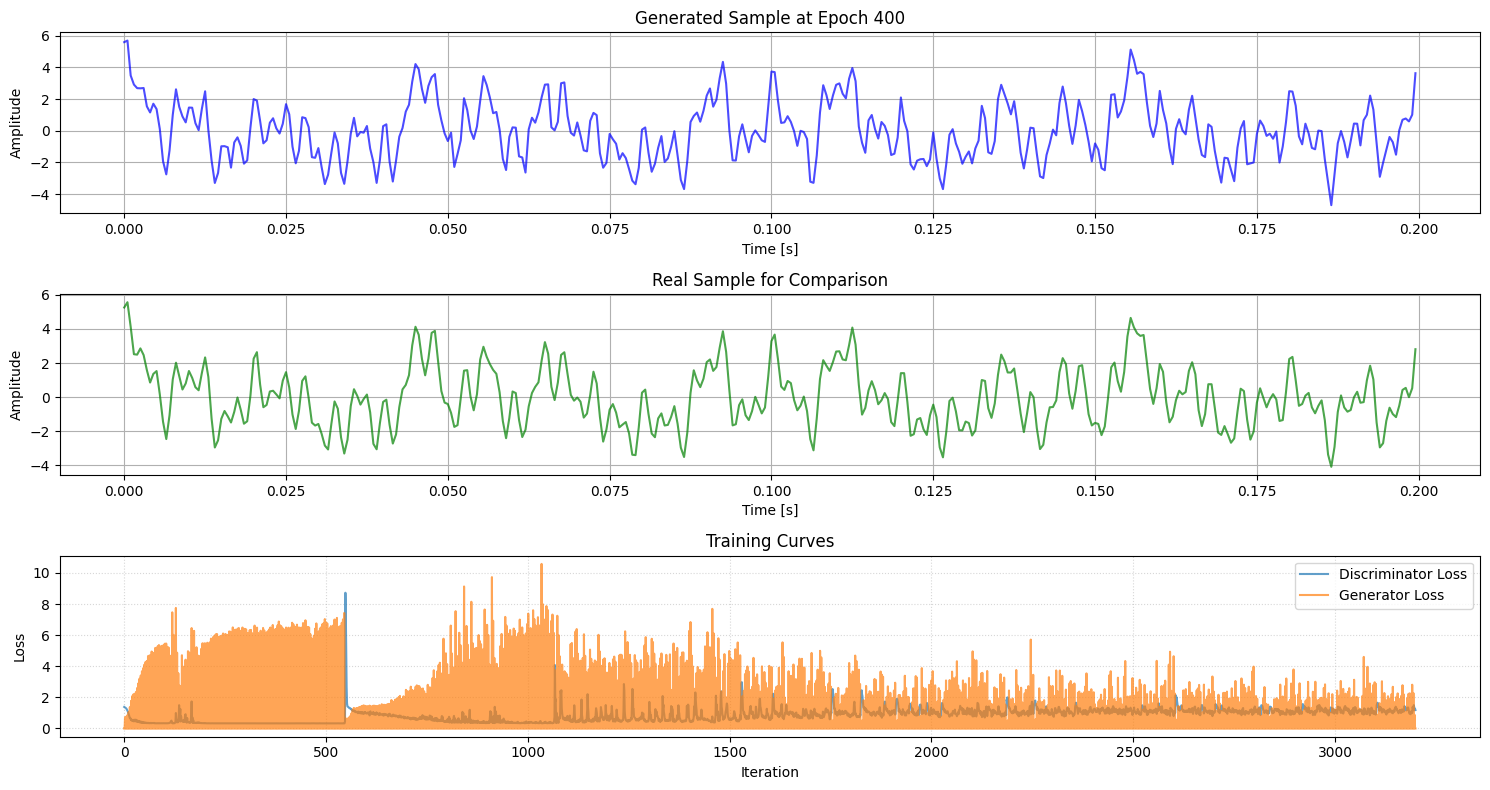

Epoch [450/1000], D Loss: 1.1099, G Loss: 2.4683
Epoch [500/1000], D Loss: 1.0151, G Loss: 0.0000


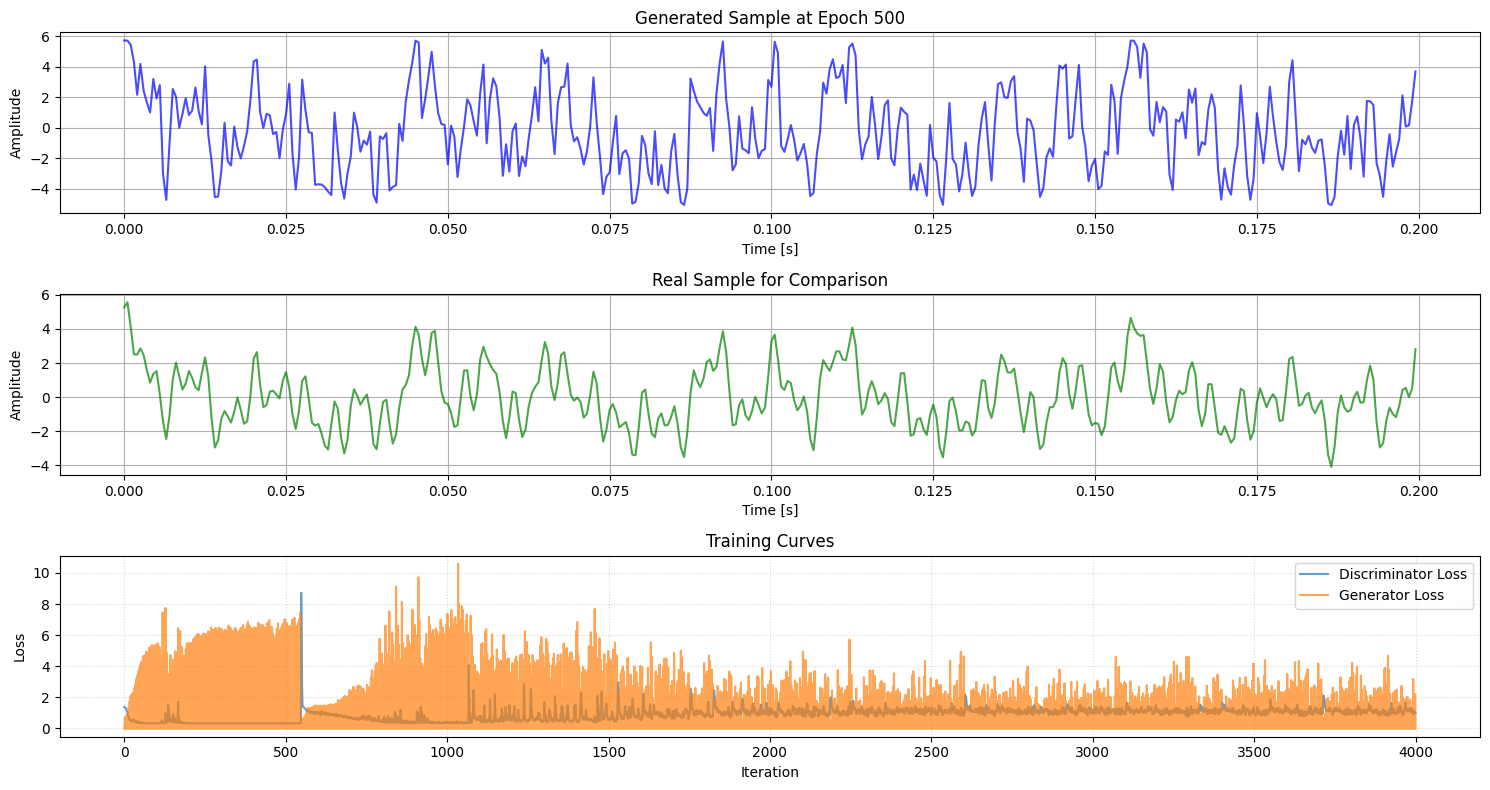

Epoch [550/1000], D Loss: 1.1608, G Loss: 0.0000
Epoch [600/1000], D Loss: 1.0149, G Loss: 1.7830


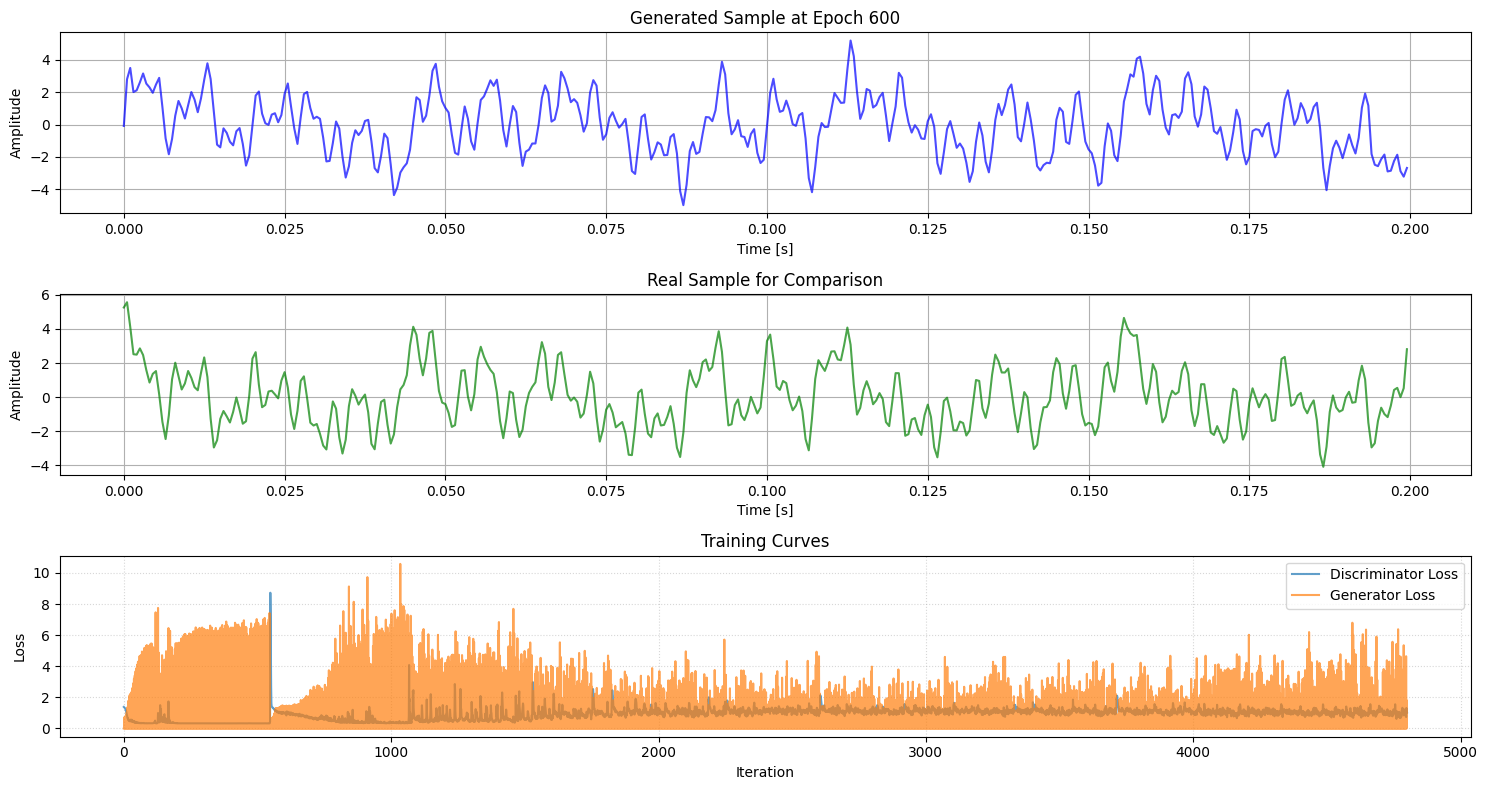

Epoch [650/1000], D Loss: 1.0645, G Loss: 0.0000
Epoch [700/1000], D Loss: 1.2566, G Loss: 0.0000


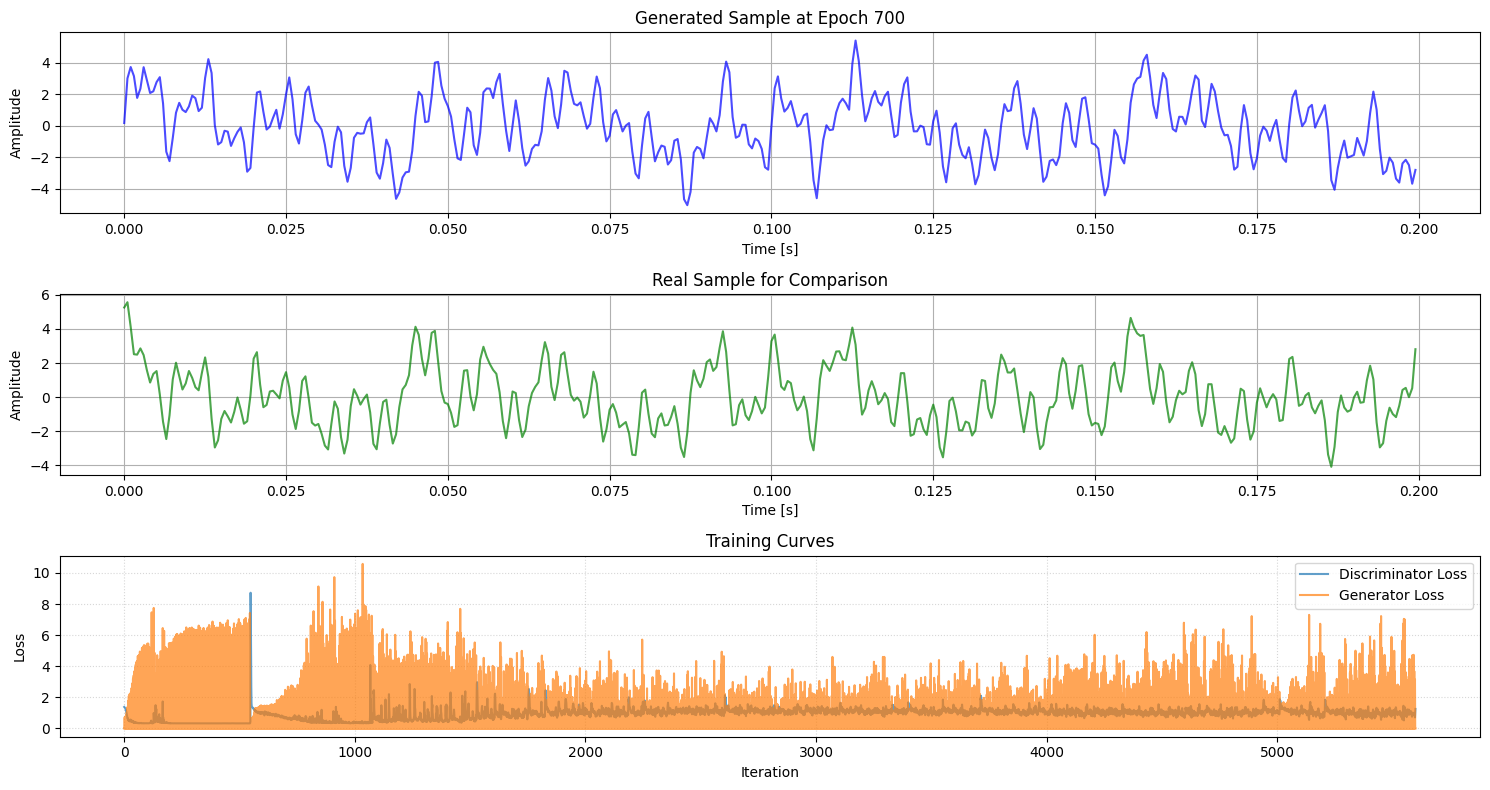

Epoch [750/1000], D Loss: 0.9896, G Loss: 3.1611
Epoch [800/1000], D Loss: 0.9636, G Loss: 0.0000


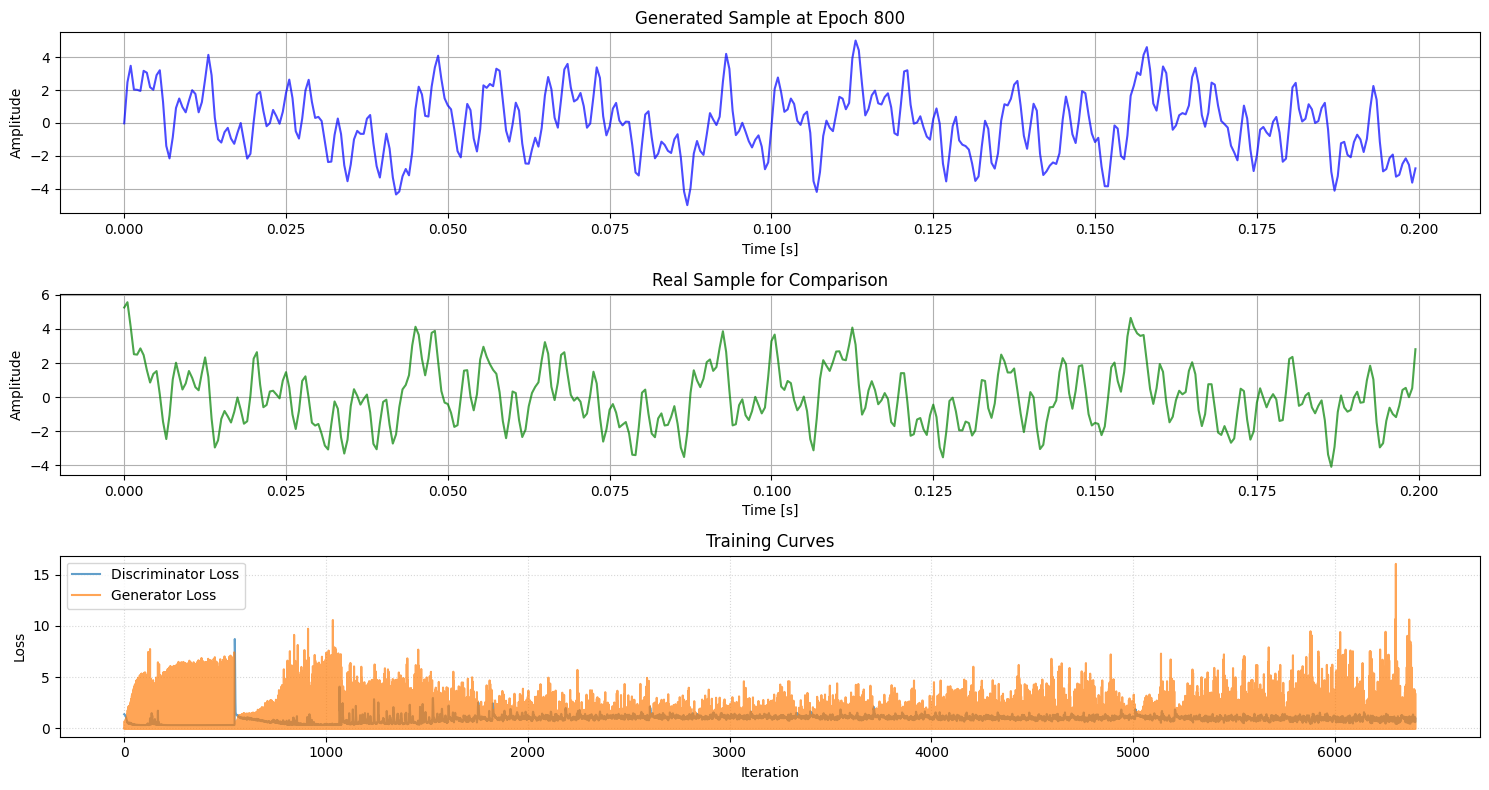

Epoch [850/1000], D Loss: 0.8149, G Loss: 0.0000
Epoch [900/1000], D Loss: 0.8340, G Loss: 4.5328


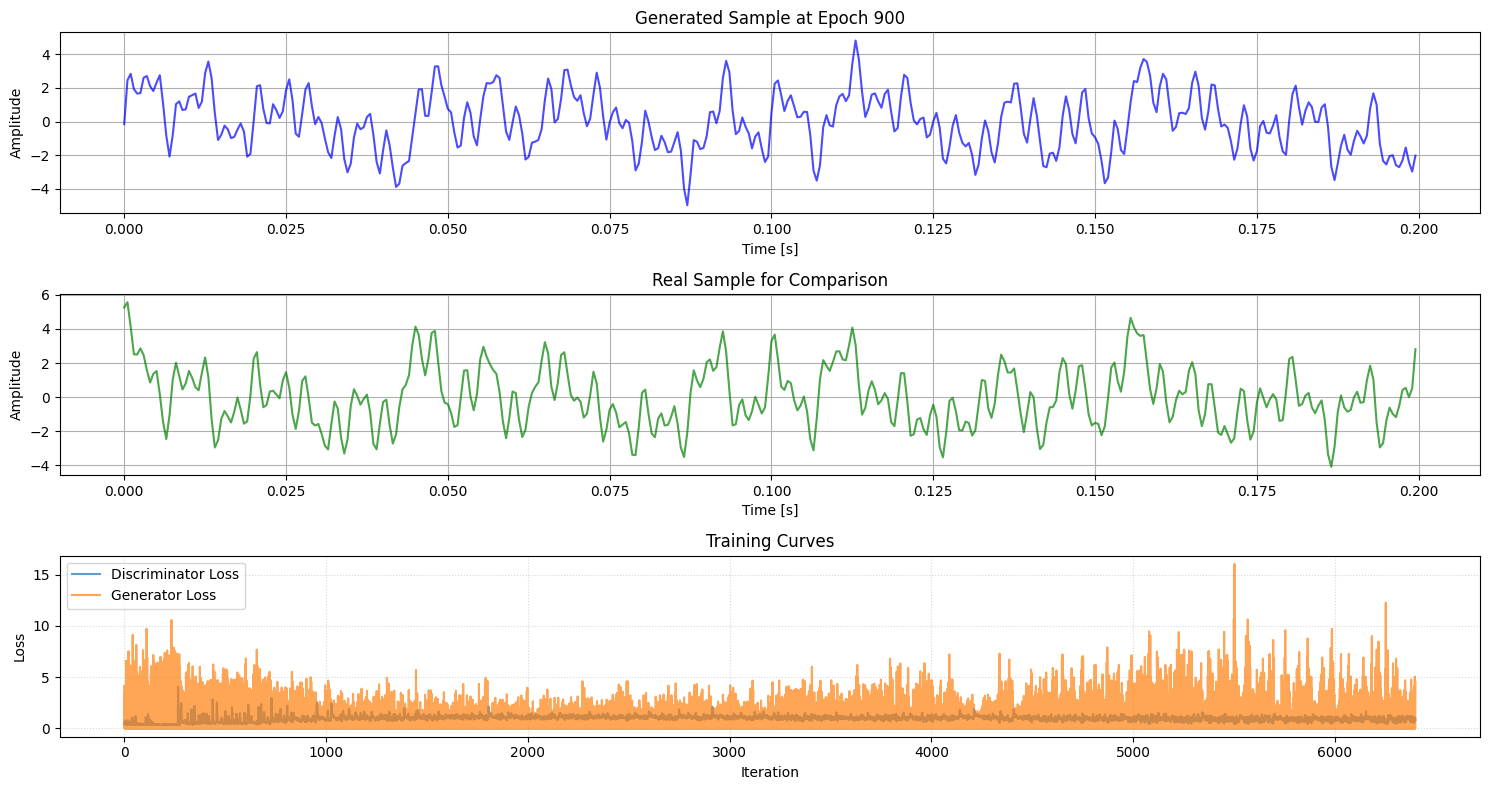

Epoch [950/1000], D Loss: 0.7391, G Loss: 0.0000
Epoch [1000/1000], D Loss: 0.6437, G Loss: 0.0000


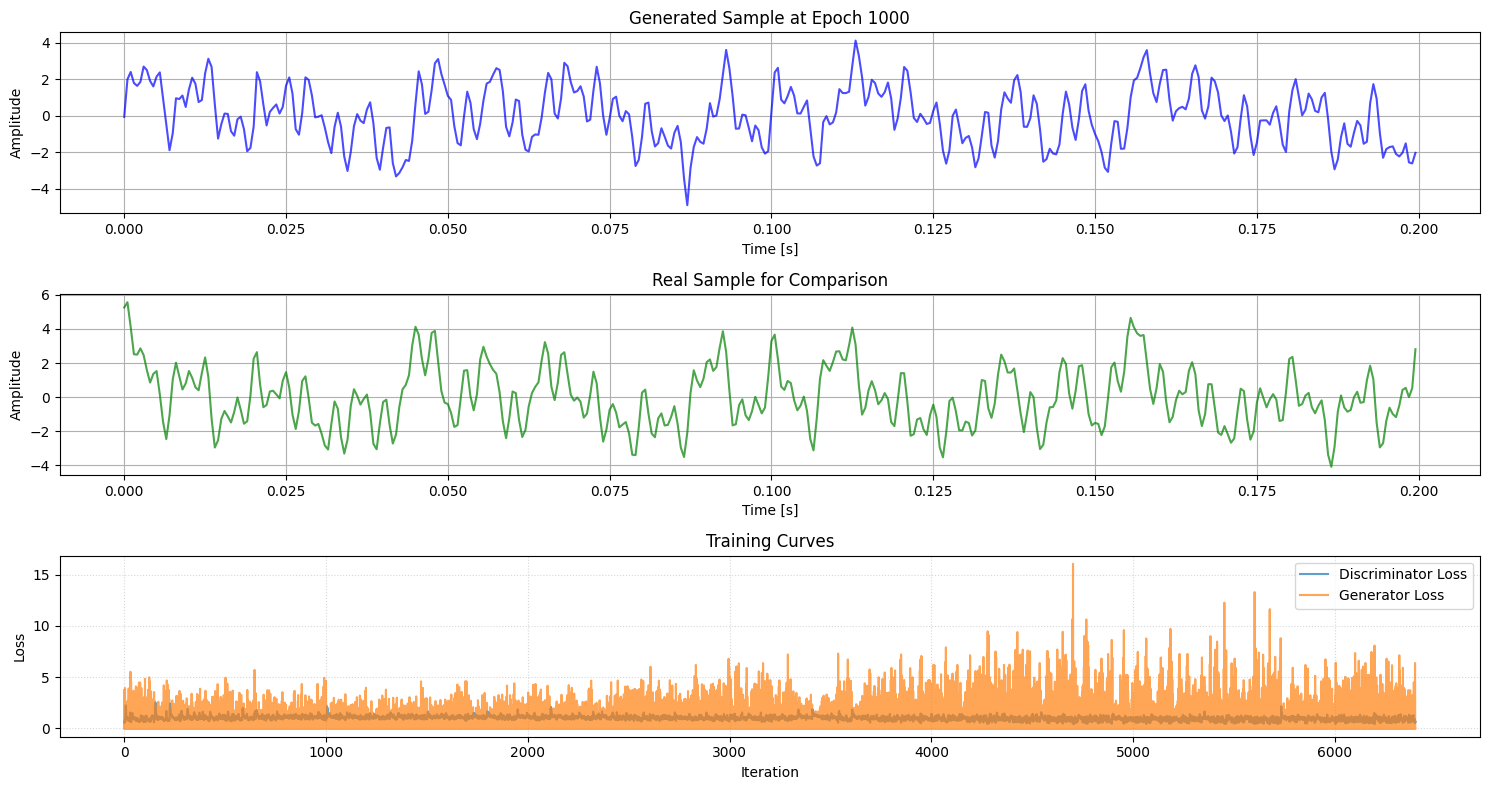

***************** Training finished!!! ****************


In [ ]:
global noise_dim
noise_dim = 128  # Aumentado para más variabilidad
batch_size = 64

class Trainer:
    def __init__(self, generator, discriminator, g_optimizer, d_optimizer, criterion, device, n_critic=3):
        self.generator = generator
        self.discriminator = discriminator
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.criterion = criterion
        self.device = device
        self.n_critic = n_critic  # Entrenar D más veces que G
        self.d_steps = 0

    def train_step(self, real_data):
        batch_size = real_data.size(0)
        real_data = real_data.to(self.device)

        # Train Discriminator (con label smoothing)
        self.d_optimizer.zero_grad()

        # Real data (label smoothing: 0.9 en vez de 1.0)
        real_labels = torch.ones(batch_size, 1).to(self.device) * 0.9
        real_outputs = self.discriminator(real_data)
        d_loss_real = self.criterion(real_outputs, real_labels)

        # Fake data
        noise = torch.randn(batch_size, noise_dim).to(self.device)
        fake_data = self.generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(self.device)
        fake_outputs = self.discriminator(fake_data.detach())
        d_loss_fake = self.criterion(fake_outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.d_optimizer.step()

        self.d_steps += 1

        # Train Generator (solo cada n_critic pasos)
        g_loss = torch.tensor(0.0)
        if self.d_steps % self.n_critic == 0:
            self.g_optimizer.zero_grad()
            noise = torch.randn(batch_size, noise_dim).to(self.device)
            fake_data = self.generator(noise)
            fake_outputs = self.discriminator(fake_data)
            g_loss = self.criterion(fake_outputs, real_labels)  # G quiere que D clasifique como real
            g_loss.backward()
            self.g_optimizer.step()

        return d_loss.item(), g_loss.item()

## Creacion del GAN vanilla mejorado

output_dim = X_dataset_normalized.shape[1]

generator = Generator(noise_dim=noise_dim, output_dim=output_dim).to(device)
discriminator = Discriminator(input_dim=output_dim).to(device)

# Inicializar pesos
generator.apply(weights_init)
discriminator.apply(weights_init)

# Learning rates diferenciados
g_optimizer = Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()

trainer = Trainer(generator, discriminator, g_optimizer, d_optimizer, criterion, device, n_critic=3)

num_epochs = 1000  # Aumentado para mejor convergencia
g_errors = []
d_errors = []

EPOCHS_TO_PLOT = 100
LOSS_MAX_VIEW = batch_size * EPOCHS_TO_PLOT

# Usar datos normalizados
dataloader_normalized = get_dataloader(X_dataset_normalized, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for real_data in dataloader_normalized:
        d_loss, g_loss = trainer.train_step(real_data)
        d_errors.append(d_loss)
        g_errors.append(g_loss)

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}')

    if (epoch+1) % EPOCHS_TO_PLOT == 0:
        plt.figure(figsize=(15, 8))
        generator.eval()
        with torch.no_grad():
            noise = torch.randn(1, noise_dim).to(device)
            generated_data = generator(noise).cpu().detach().numpy().reshape(-1)
            # Desnormalizar para comparar con datos originales
            generated_data_denorm = (generated_data + 1) / 2 * (X_max - X_min) + X_min
        generator.train()

        # Subplot 1: Señal generada
        plt.subplot(3, 1, 1)
        plt.plot(Gen_DB_sin_instance.t, generated_data_denorm, color='blue', alpha=0.7)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.title(f'Generated Sample at Epoch {epoch+1}')
        plt.grid()
        
        # Subplot 2: Señal real (para comparación)
        plt.subplot(3, 1, 2)
        plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:], color='green', alpha=0.7)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.title('Real Sample for Comparison')
        plt.grid()

        # Subplot 3: Curvas de pérdida
        plt.subplot(3, 1, 3)
        plt.plot(d_errors[max(0, len(d_errors)-LOSS_MAX_VIEW):], label='Discriminator Loss', alpha=0.7)
        plt.plot(g_errors[max(0, len(g_errors)-LOSS_MAX_VIEW):], label='Generator Loss', alpha=0.7)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training Curves')
        plt.legend()
        plt.grid(ls=":", alpha=0.5)
        
        plt.tight_layout()
        plt.show()

print("***************** Training finished!!! ****************")

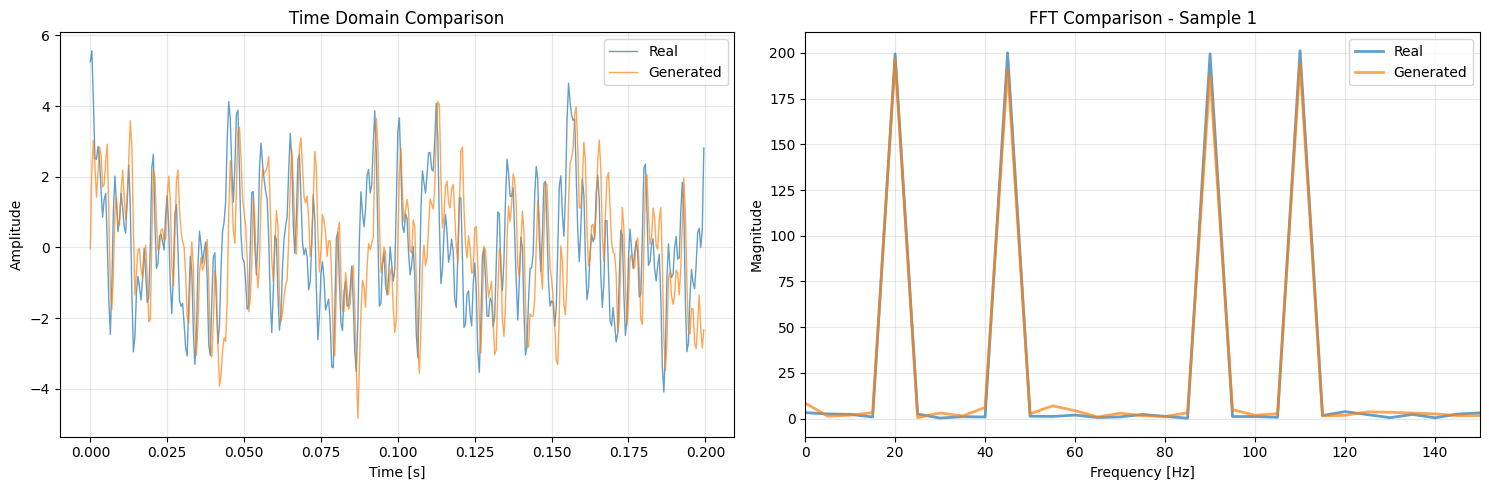

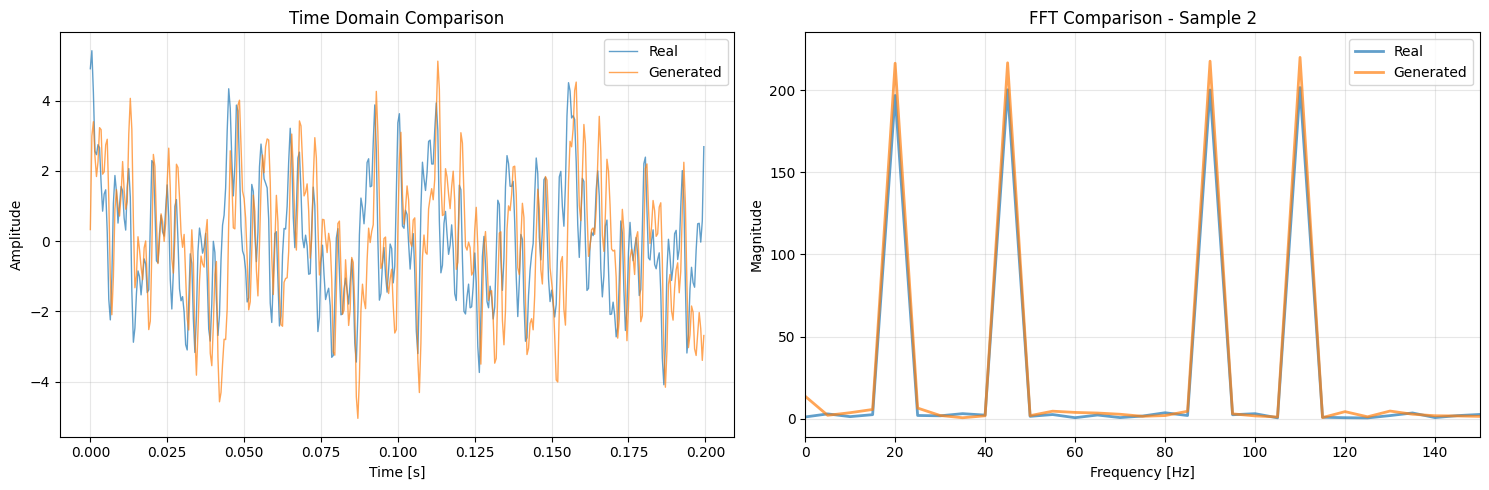

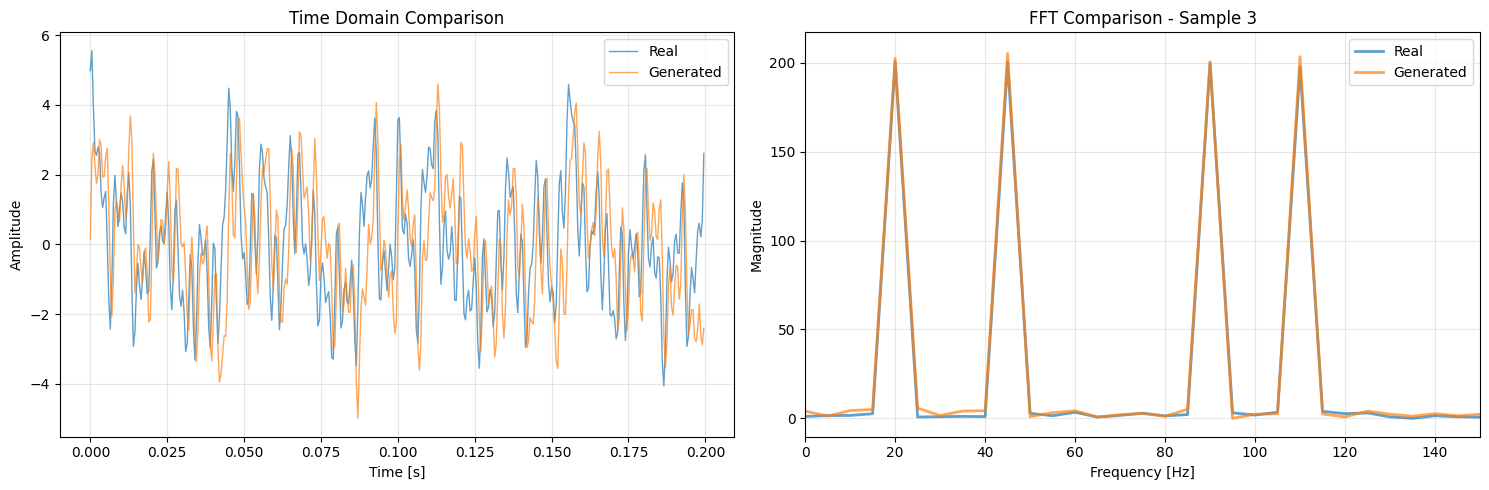

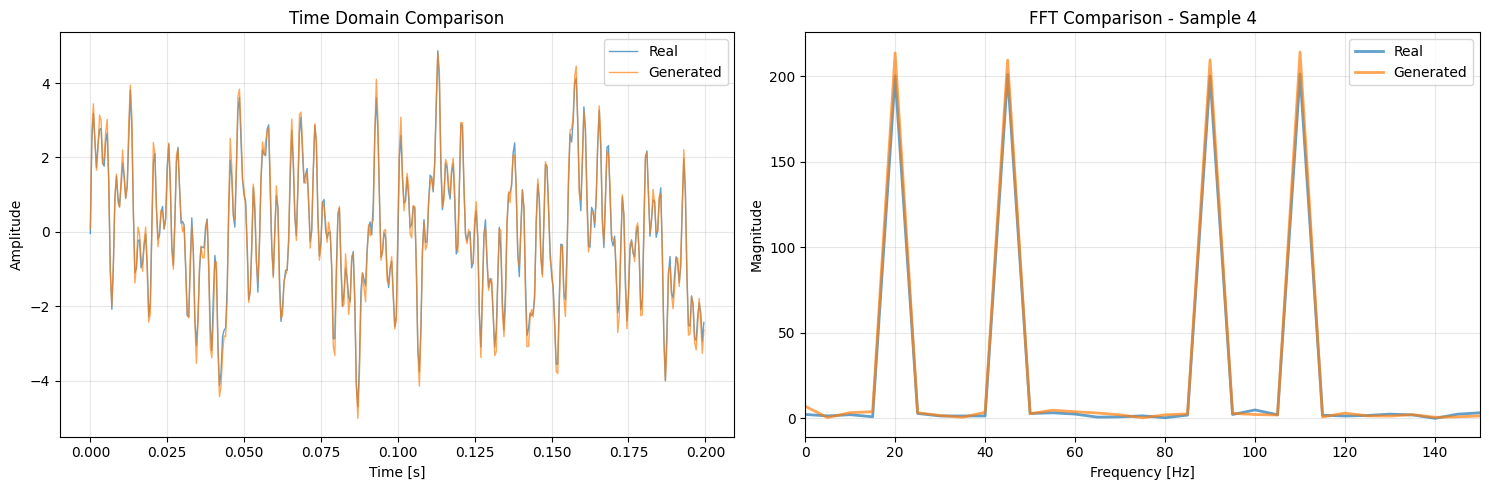

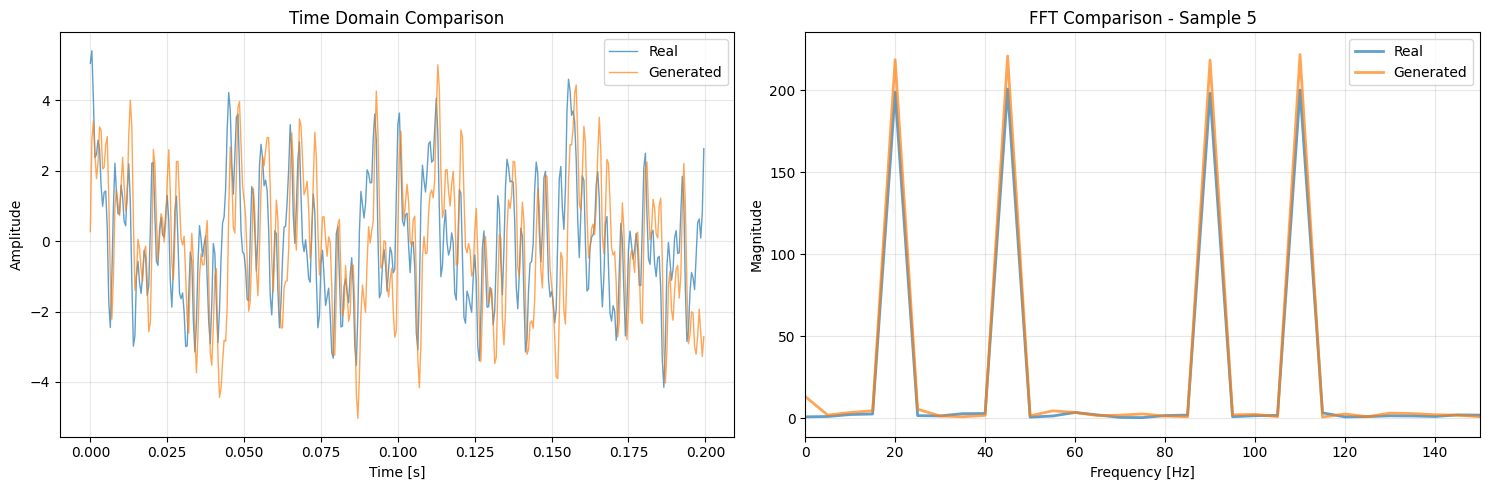

In [17]:
from scipy import signal
from scipy.fft import fft, fftfreq

def plot_fft_comparison(real_signal, generated_signal, fs, title="FFT Comparison"):
    """Compara el espectro de frecuencias de señales reales y generadas"""
    n = len(real_signal)
    
    # FFT de señal real
    fft_real = np.abs(fft(real_signal))
    fft_real = fft_real[:n//2]
    
    # FFT de señal generada
    fft_gen = np.abs(fft(generated_signal))
    fft_gen = fft_gen[:n//2]
    
    # Frecuencias
    freqs = fftfreq(n, 1/fs)[:n//2]
    
    plt.figure(figsize=(15, 5))
    
    # Señales en el tiempo
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(n)/fs, real_signal, label='Real', alpha=0.7, linewidth=1)
    plt.plot(np.arange(n)/fs, generated_signal, label='Generated', alpha=0.7, linewidth=1)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Time Domain Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Espectros de frecuencia
    plt.subplot(1, 2, 2)
    plt.plot(freqs, fft_real, label='Real', alpha=0.7, linewidth=2)
    plt.plot(freqs, fft_gen, label='Generated', alpha=0.7, linewidth=2)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0, 150)  # Enfocarse en las frecuencias de interés (20, 50, 80, 100 Hz)
    
    # Marcar frecuencias esperadas
    #for f in [20, 50, 80, 100]:
    #    plt.axvline(f, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
    
    plt.tight_layout()
    plt.show()

# Generar múltiples muestras y evaluar
generator.eval()
with torch.no_grad():
    noise = torch.randn(5, noise_dim).to(device)
    generated_samples = generator(noise).cpu().detach().numpy()
    # Desnormalizar
    generated_samples = (generated_samples + 1) / 2 * (X_max - X_min) + X_min

generator.train()

# Comparar con señales reales
for i in range(5):
    plot_fft_comparison(
        X_dataset[i], 
        generated_samples[i], 
        Gen_DB_sin_instance.fs,
        title=f"FFT Comparison - Sample {i+1}"
    )